In [1]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


In [2]:
from sentinelhub import SHConfig
from dotenv import load_dotenv
import os
import numpy as np
from utils import get_map
import datetime
import os
import matplotlib.pyplot as plt
import numpy as np
from sentinelhub import CRS, BBox, bbox_to_dimensions
from utils import evalscript_true_color, evalscript_ndvi, evalscript_ndwi
from utils import center_crop
from config import IMAGE_SIZE
from utils import to_grayscale
import cv2
from utils import generated_lsm_mask
from PIL import Image
import config
import numpy as np
from torch.utils.data import DataLoader
from dataset import Image_dataset
from generator_model import Generator
from torch import optim
import torch
from config import DEVICE

gen = Generator(in_channels=1, inter_images=4, out_channels=1)
checkpoint = torch.load("model/gen_LSM_v1.pth.tar", map_location=torch.device(DEVICE))
gen.load_state_dict(checkpoint['state_dict'])
optimizer = optim.Adam(gen.parameters())
optimizer.load_state_dict(checkpoint['optimizer'])

config_sentinel = SHConfig(sh_client_id=os.environ.get("sh_client_id"), sh_client_secret=os.environ.get("sh_client_secret"))
config_sentinel.sh_client_id

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <2BD1B165-EC09-3F68-BCE4-8FE4E70CA7E2> /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <9C467D80-5BAC-3156-B480-F0FF7E45DEF2> /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/lib/libt

torch.Size([5, 128, 100, 100])


/var/folders/3p/xlr6tgyx4t980qpxnnrs12kc0000gn/T/ipykernel_45003/4051600854.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("model/gen_LSM_v1.pt

'65f2b211-b283-42d5-9ac6-d3ecf4be5a45'

In [ ]:
from sentinelhub import BBox, bbox_to_dimensions, CRS
import math

def divide_bbox(cords, resolution, grid_size):
    # Original bounding box
    bbox = BBox(bbox=cords, crs=CRS.WGS84)

    # Dimensions of the entire bounding box in pixels
    original_size = bbox_to_dimensions(bbox, resolution=resolution)
    print(f"Original bounding box dimensions: {original_size}")

    # Pixel-to-degree conversion
    grid_width_m = grid_size[0] * resolution  # Grid width in meters
    grid_height_m = grid_size[1] * resolution  # Grid height in meters

    # Convert meters to degrees (approximation using latitude for longitude adjustment)
    lat_extent = cords[3] - cords[1]  # Max lat - Min lat
    lon_extent = cords[2] - cords[0]  # Max lon - Min lon
    lat_to_m = 111000  # Approximate meters per degree of latitude
    lon_to_m = 111000 * abs(math.cos(math.radians((cords[1] + cords[3]) / 2)))  # Adjust for longitude

    lat_step = grid_height_m / lat_to_m  # Latitude step in degrees
    lon_step = grid_width_m / lon_to_m  # Longitude step in degrees

    # Generate sub-boxes
    sub_boxes = []
    lat_start = cords[1]
    while lat_start + lat_step <= cords[3]:
        row = []
        lon_start = cords[0]
        while lon_start + lon_step <= cords[2]:
            row.append((
                lon_start,
                lat_start,
                lon_start + lon_step,
                lat_start + lat_step
            ))
            lon_start += lon_step
        sub_boxes.append(row)
        lat_start += lat_step

    return sub_boxes

# Example usage
{"type":"Polygon","coordinates":[[[80.09958,12.89979],[80.094506,12.89979],[80.094506,12.904873],[80.09958,12.904873],[80.09958,12.89979]]]}
cords = (80.094506, 12.89979, 80.09958, 12.904873)
resolution = 0.8  # meters per pixel
grid_size = (1000, 1000)  # 1000x1000 pixels
sub_boxes = divide_bbox(cords, resolution, grid_size)

rows = len(sub_boxes[0])
columns = len(sub_boxes[0][0])

print("rows: ", rows)
print("columns: ", columns)

In [321]:
import math

def add_km_to_lat_long(lat, lon, d_lat_km, d_lon_km):
    new_lat = lat + (d_lat_km / 111)
    new_lon = lon + (d_lon_km / (111 * math.cos(math.radians(lat))))
    return new_lat, new_lon

In [323]:
import numpy as np
import folium

grid = 3
additional_km = 1.4 * grid # dont change/exceed this
# grid = 5

a = {"type":"Polygon","coordinates":[[[54.960823,24.985747],[55.017471,24.985747],[55.017471,25.032417],[54.960823,25.032417],[54.960823,24.985747]]]}
min_lon, min_lat = a['coordinates'][0][0][0], a['coordinates'][0][0][1] # Lower-left corner

max_lat, max_lon = add_km_to_lat_long(min_lat, min_lon, additional_km, additional_km)

lon = np.linspace(min_lon, max_lon, grid+1)
lat = np.linspace(min_lat, max_lat, grid+1)

latlons = []
for i in range(len(lat)-1):
    for k in range(len(lon)-1):
        latlons.append((lat[k], lon[i], lat[k+1], lon[i+1]))

m = folium.Map(location=((min_lat+max_lat)/2,(min_lon+max_lon)/2), zoom_start=11)
cords = []
for k in latlons:
    cord = [(k[0], k[1]), (k[2], k[3])]
    cords.append([k[1], k[0], k[3], k[2]])
    folium.Rectangle(cord, color='red', fill='pink',fill_opcity=0.5).add_to(m)
m

In [324]:
actual_grid = []
for row in range(grid):
    g = []
    for col in range(grid):
        g.append(cords[row * grid + col])  # Correct indexing
    actual_grid.append(g)

sub_boxes = np.array(actual_grid)

In [329]:
from tqdm import tqdm
from time import time

def generate_grid_pred(cords_grid, columns=None, rows=None):

    if not columns: columns = len(cords_grid[0])
    if not rows: rows = len(cords_grid)
    
    grid_pred, grid_gray = [], []
    resolution = 0.8
    for row in tqdm(cords_grid[:rows], total=rows): 
        grid_pred_row, grid_gray_row = [], []
        for column in row[:columns]:  
            column = list(column)
            # import pdb; pdb.set_trace()
            maps = get_map(column, start_date="2024-11-06", end_date="2024-12-06",
                evalscript_ndvi=evalscript_ndvi,
                evalscript_true_color=evalscript_true_color,
                evalscript_ndwi=evalscript_ndwi)
            
            new_shape = (IMAGE_SIZE, IMAGE_SIZE)

            gray_image = cv2.resize(to_grayscale(maps[0]), (new_shape[0], new_shape[1]))
            NDVI = cv2.resize(maps[1], (new_shape[0], new_shape[1]))
            Slope = cv2.resize(maps[2], (new_shape[0], new_shape[1]))
            Elevation = cv2.resize(maps[3], (new_shape[0], new_shape[1]))
            NDWI = cv2.resize(maps[4], (new_shape[0], new_shape[1]))

            gray_image_n = cv2.normalize(gray_image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
            NDVI_n = cv2.normalize(NDVI, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
            Slope_n = cv2.normalize(Slope, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
            Elevation_n = cv2.normalize(Elevation, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
            NDWI_n = cv2.normalize(NDWI, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

            canvas = np.ones((128, 128*5))
            canvas[:, 0:128] = gray_image_n
            canvas[:, 128:128*2] = NDVI_n
            canvas[:, 128*2:128*3] = Slope_n
            canvas[:, 128*3:128*4] = Elevation_n
            canvas[:, 128*4:128*5] = NDWI_n

            pred = generated_lsm_mask(gen, canvas, already_grayscale=True)
            grid_pred_row.append(pred)
            grid_gray_row.append(gray_image_n)
        grid_pred.append(grid_pred_row)
        grid_gray.append(grid_gray_row)
        
    return grid_pred, grid_gray

    

In [330]:
a = generate_grid_pred(sub_boxes)


100%|██████████| 3/3 [02:27<00:00, 49.16s/it]


In [331]:
from config import IMAGE_RESIZED

rows = len(a[0])
columns = len(a[0][0])
option = 1

grid_canvas = np.zeros((IMAGE_RESIZED*rows, IMAGE_RESIZED*columns))
for row in range(rows):
    for column in range(columns):
        start_row = row * IMAGE_RESIZED
        end_row = (row + 1) * IMAGE_RESIZED
        start_col = column * IMAGE_RESIZED
        end_col = (column + 1) * IMAGE_RESIZED
        # Swap rows and columns and flip rows
        flipped_row = rows - 1 - row
        grid_canvas[start_row:end_row, start_col:end_col] = cv2.resize(a[option][column][flipped_row], (IMAGE_RESIZED, IMAGE_RESIZED))

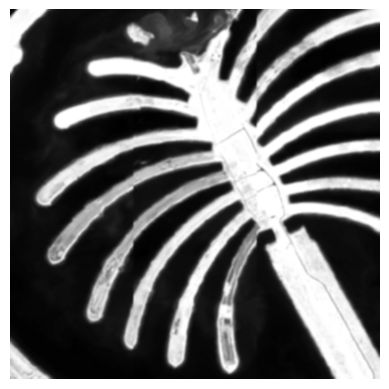

In [335]:
blurred_image = cv2.blur(grid_canvas, (5,5))
mask = (blurred_image > 0.3) & (blurred_image < 0.4) * 1

plt.imshow(blurred_image, cmap="gray")
plt.axis("off")
plt.show()

In [315]:
mask*1

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

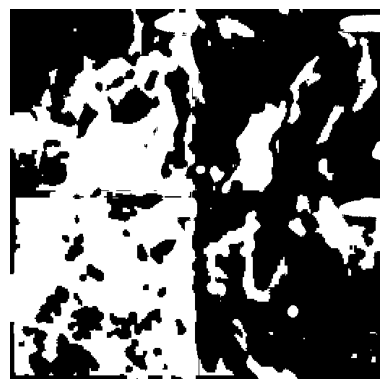

In [123]:
plt.imshow(cv2.blur(grid_canvas, (10,10))>0.2, cmap="gray")
plt.axis("off")
plt.show()

In [9]:

cords = sub_boxes[0]

resolution = 0.8
bbox = BBox(bbox=cords, crs=CRS.WGS84)
size = bbox_to_dimensions(bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {size} pixels")

Image shape at 0.8 m resolution: (987, 1020) pixels


In [10]:
maps = get_map(cords, start_date="2021-06-12", end_date="2023-06-13", 
        evalscript_ndvi=evalscript_ndvi, 
        evalscript_true_color=evalscript_true_color, 
        evalscript_ndwi=evalscript_ndwi)

In [ ]:
# gray_image, NDVI, Slope, Elevation, NDWI

In [11]:
new_shape = (IMAGE_SIZE, IMAGE_SIZE)

gray_image = cv2.resize(to_grayscale(maps[0]), (new_shape[0], new_shape[1]))
NDVI = cv2.resize(maps[1], (new_shape[0], new_shape[1]))
Slope = cv2.resize(maps[2], (new_shape[0], new_shape[1]))
Elevation = cv2.resize(maps[3], (new_shape[0], new_shape[1]))
NDWI = cv2.resize(maps[4], (new_shape[0], new_shape[1]))

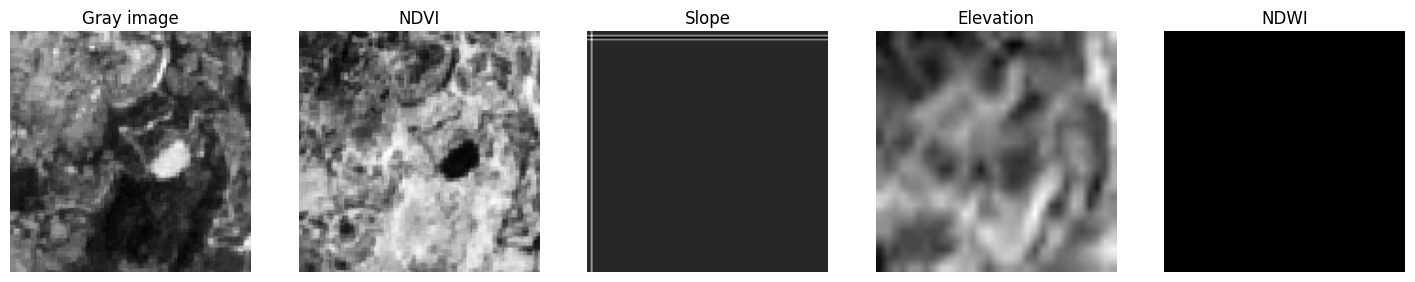

In [12]:
fig,(ax1,ax2, ax3, ax4, ax5)= plt.subplots(1,5,figsize=(18,6))

ax1.set_title("Gray image")
ax2.set_title("NDVI")
ax3.set_title("Slope")
ax4.set_title("Elevation")
ax5.set_title("NDWI")

ax1.imshow(gray_image, cmap="gray")
ax2.imshow(NDVI, cmap="gray")
ax3.imshow(Slope, cmap="gray")
ax4.imshow(Elevation, cmap="gray")
ax5.imshow(NDWI, cmap="gray")

ax1.axis("off"); ax2.axis("off"), ax3.axis("off"); ax4.axis("off"), ax5.axis("off")
plt.show()


In [13]:
gray_image_n = cv2.normalize(gray_image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
NDVI_n = cv2.normalize(NDVI, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
Slope_n = cv2.normalize(Slope, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
Elevation_n = cv2.normalize(Elevation, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
NDWI_n = cv2.normalize(NDWI, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

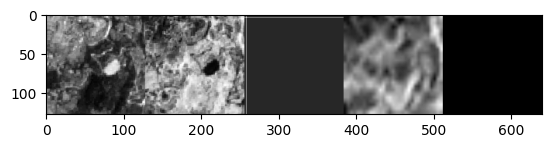

In [14]:
canvas = np.ones((128, 128*5))
canvas[:, 0:128] = gray_image_n
canvas[:, 128:128*2] = NDVI_n
canvas[:, 128*2:128*3] = Slope_n
canvas[:, 128*3:128*4] = Elevation_n
canvas[:, 128*4:128*5] = NDWI_n

plt.imshow(canvas, cmap="gray")

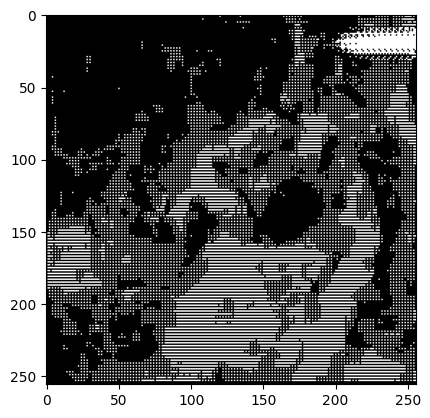

In [170]:
pred = generated_lsm_mask(gen, canvas, already_grayscale=True)
plt.imshow(pred, cmap="gray")